<a href="https://colab.research.google.com/github/vignesh-pala/NLP/blob/master/NLP_Ch13_SpamDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Challenge 13 (NLP with Keras-TF2)**

Try to predict spam emails using RNNs (LSTM) in Keras. See if it improves the performance of normal MLPs in Keras. Data set attached.

 

Go through this link for a refresher on RNNs

https://pathmind.com/wiki/lstm

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.stem import WordNetLemmatizer

from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
import tensorflow.keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense,Embedding,LSTM,Dropout,Bidirectional,GRU, Input, Activation, Flatten, Bidirectional, GlobalMaxPool1D, SpatialDropout1D
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import models, layers
from keras.layers import  CuDNNLSTM # NA in tensorflow.keras

nltk.download('wordnet')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [3]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/TextFiles/datasets_spam.csv',encoding='latin-1')

In [5]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


Remove the junk fields

In [9]:
df = df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis = 1)

Rename the Columns to make it meanigful

In [11]:
df.columns = ['label', 'text']

Convert Labels to numeric

In [15]:
df['label'] = pd.get_dummies(df['label'], drop_first=True)

The classes are heavily biased

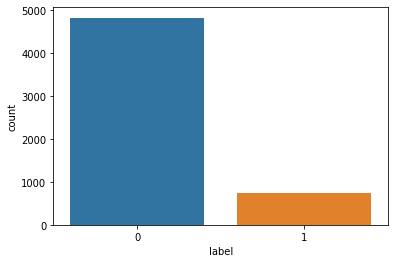

In [18]:
sns.countplot(df['label'])

**Text Cleaning/Preprocessing**

In [26]:
stopwords = set(STOPWORDS)
wordnet_lemmatizer = WordNetLemmatizer()

In [27]:
def lemmmatizer_stopwords(text):
    final_text = []
    for i in text.split():
        lemma = wordnet_lemmatizer.lemmatize(i.strip().lower(), pos='v')
        if lemma not in stopwords:
            final_text.append(lemma)
    return " ".join(final_text)

In [28]:
df['text'] = df['text'].apply(lemmmatizer_stopwords)

**EDA / WordCloud Genertation**

In [32]:
df['text_len'] = df.text.apply(lambda x: len(x.split()))

In [51]:
df.groupby(['label']).text_len.mean()

label
0     8.384249
1    17.520750
Name: text_len, dtype: float64

**As we can see, the Avg length of Spams are more than double than Ham**

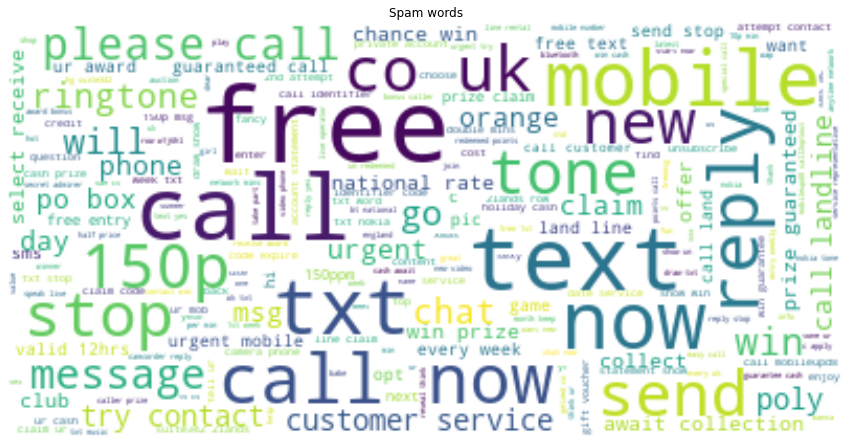

In [31]:
fig, ax = plt.subplots(figsize=(15,10 ))

# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords=stopwords, background_color="white",max_font_size=50,max_words=500).generate(" ".join(df[df.label ==1].text))

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Spam words")
plt.show()

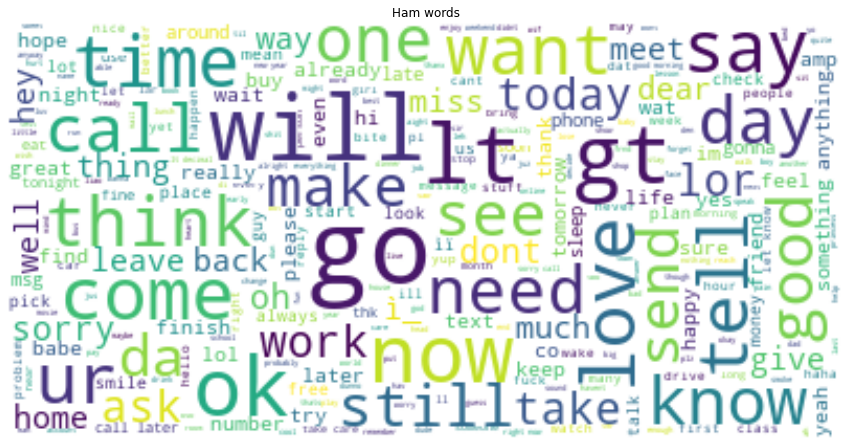

In [30]:
fig, ax = plt.subplots(figsize=(15,10 ))

# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords=stopwords, background_color="white",max_font_size=50,max_words=500).generate(" ".join(df[df.label ==0].text))

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Ham words")
plt.show()

**The WordCloud itself shows the difference in vocabaulary between Spam and Ham words :)**

In [37]:
text = df['text']
label = df['label']

In [38]:
train_sentences, test_sentences, train_labels, test_labels = train_test_split(text, label, test_size=0.2, stratify=label, random_state=42)

In [36]:
#Defining Hyperparameters to be used

max_words = 30000     # how many unique words to use (i.e num rows in embedding vector)
max_len = 70       # max number of words in a headline to use
oov_token = '00_V'    # for the words which are not in training samples
padding_type = 'post'   # padding type
trunc_type = 'post'    # truncation for headlines longer than max length
embed_size = 100    # how big is each word vector

In [39]:
tokenizer = Tokenizer(num_words=max_words, oov_token=oov_token)
tokenizer.fit_on_texts(train_sentences)

word_index = tokenizer.word_index

In [40]:
train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_sequences = pad_sequences(train_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)

test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_sequences = pad_sequences(test_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)

**Simple Neural Network with Embedding Layer**

In [41]:

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_words, embed_size, input_length=max_len),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 70, 100)           3000000   
_________________________________________________________________
global_max_pooling1d (Global (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 16)                1616      
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 3,001,633
Trainable params: 3,001,633
Non-trainable params: 0
_________________________________________________________________


In [43]:
history = model.fit(train_sequences, train_labels, batch_size=32, epochs=5, 
                    validation_data=(test_sequences, test_labels), 
                    verbose=1)

Epoch 1/5
140/140 [==============================] - 5s 35ms/step - loss: 0.5054 - accuracy: 0.8304 - val_loss: 0.3685 - val_accuracy: 0.8664
Epoch 2/5
140/140 [==============================] - 5s 35ms/step - loss: 0.3227 - accuracy: 0.8692 - val_loss: 0.2368 - val_accuracy: 0.8771
Epoch 3/5
140/140 [==============================] - 5s 35ms/step - loss: 0.1472 - accuracy: 0.9520 - val_loss: 0.0988 - val_accuracy: 0.9740
Epoch 4/5
140/140 [==============================] - 5s 36ms/step - loss: 0.0597 - accuracy: 0.9886 - val_loss: 0.0624 - val_accuracy: 0.9803
Epoch 5/5
140/140 [==============================] - 5s 35ms/step - loss: 0.0270 - accuracy: 0.9942 - val_loss: 0.0511 - val_accuracy: 0.9839


35/35 [==============================] - 0s 1ms/step - loss: 0.0511 - accuracy: 0.9839
Test Loss:  0.05111837759613991
Test Accuracy 0.9838564991950989
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


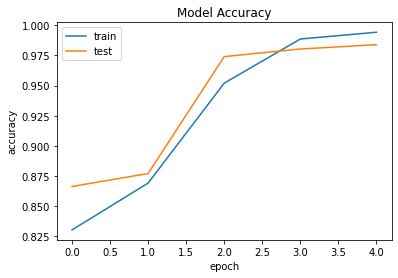

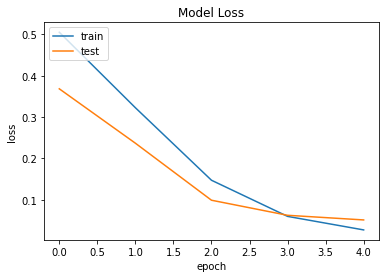

In [44]:
score = model.evaluate(test_sequences, test_labels)
print('Test Loss: ', score[0])
print('Test Accuracy', score[1])


# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**RNN with LSTM**

In [48]:
model_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_words, embed_size, input_length=max_len),
    tf.keras.layers.SpatialDropout1D(0.2),
    tf.keras.layers.LSTM(32, dropout=0.2, recurrent_dropout=0.2, return_sequences=True),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 70, 100)           3000000   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 70, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 70, 32)            17024     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 16)                528       
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

In [49]:
history_lstm = model_lstm.fit(train_sequences, train_labels, batch_size=32, epochs=5, 
                    validation_data=(test_sequences, test_labels), verbose=1)

Epoch 1/5
140/140 [==============================] - 16s 111ms/step - loss: 0.4000 - accuracy: 0.8782 - val_loss: 0.1616 - val_accuracy: 0.9668
Epoch 2/5
140/140 [==============================] - 15s 108ms/step - loss: 0.0980 - accuracy: 0.9803 - val_loss: 0.0902 - val_accuracy: 0.9749
Epoch 3/5
140/140 [==============================] - 15s 108ms/step - loss: 0.0515 - accuracy: 0.9899 - val_loss: 0.0582 - val_accuracy: 0.9883
Epoch 4/5
140/140 [==============================] - 15s 107ms/step - loss: 0.0602 - accuracy: 0.9832 - val_loss: 0.1028 - val_accuracy: 0.9731
Epoch 5/5
140/140 [==============================] - 19s 135ms/step - loss: 0.0325 - accuracy: 0.9939 - val_loss: 0.0904 - val_accuracy: 0.9803


35/35 [==============================] - 0s 9ms/step - loss: 0.0904 - accuracy: 0.9803
Test Loss:  0.09041997790336609
Test Accuracy 0.9802690744400024
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


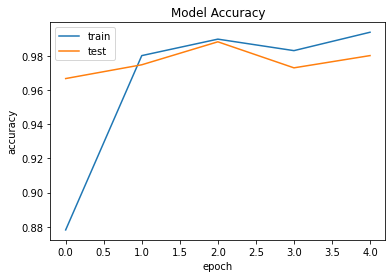

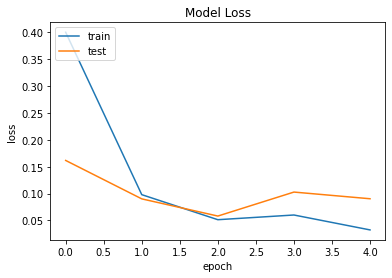

In [52]:
score = model_lstm.evaluate(test_sequences, test_labels)
print('Test Loss: ', score[0])
print('Test Accuracy', score[1])


# list all data in history
print(history_lstm.history.keys())
# summarize history for accuracy
plt.plot(history_lstm.history['accuracy'])
plt.plot(history_lstm.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_lstm.history['loss'])
plt.plot(history_lstm.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Findings:**
* A simple NeuralNet with Emedding Layer is performing well, but after few Epochs.
* However, a RNN with LSTM layer is giving > 96% Accuracy from the first Epoch itself. 
* We can beleive that with little more cleaning, preprocessing and Hyperparameter Tuning, RNN will deliver close to 100% Accuracy